In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l
from PIL import Image

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

In [3]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]  # readlines()返回一个字符串列表
    # strip()用于整理字符串，删除开头和结尾的空格和换行符
    # split()也会返回一个切分后的字符串列表
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))
print(labels)

# 训练样本 : 1000
# 类别 : 10
{'1': 'frog', '2': 'truck', '3': 'truck', '4': 'deer', '5': 'automobile', '6': 'automobile', '7': 'bird', '8': 'horse', '9': 'ship', '10': 'cat', '11': 'deer', '12': 'horse', '13': 'horse', '14': 'bird', '15': 'truck', '16': 'truck', '17': 'truck', '18': 'cat', '19': 'bird', '20': 'frog', '21': 'deer', '22': 'cat', '23': 'frog', '24': 'frog', '25': 'bird', '26': 'frog', '27': 'cat', '28': 'dog', '29': 'deer', '30': 'airplane', '31': 'airplane', '32': 'truck', '33': 'automobile', '34': 'cat', '35': 'deer', '36': 'airplane', '37': 'cat', '38': 'horse', '39': 'cat', '40': 'cat', '41': 'dog', '42': 'bird', '43': 'bird', '44': 'horse', '45': 'automobile', '46': 'automobile', '47': 'automobile', '48': 'bird', '49': 'bird', '50': 'airplane', '51': 'truck', '52': 'dog', '53': 'horse', '54': 'truck', '55': 'bird', '56': 'bird', '57': 'dog', '58': 'bird', '59': 'deer', '60': 'cat', '61': 'automobile', '62': 'automobile', '63': 'ship', '64': 'bird', '65': 'automobile', '66

In [4]:
"""
# 构建Dataset (第一种方法)
class_name = list(set(labels.values()))
class2idx = dict([(each, i) for i, each in enumerate(class_name)])

class MyDataset(Dataset):
    def __init__(self, img2label, class2idx, root_dir, img_dir):
        self.img2label = img2label
        self.class2idx = class2idx
        self.root_dir = root_dir
        self.img_dir = img_dir
        self.img_path = os.path.join(self.root_dir, self.img_dir)
        self.img_name = os.listdir(self.img_path)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_path, self.img_name[idx]))
        pic_idx = self.img_name[idx].strip().split('.')[0]
        label = self.class2idx[self.img2label[pic_idx]]
        return img, label

    def __len__(self):
        return len(self.img_name)

root_dir = '../data/kaggle_cifar10_tiny'
train_img_dir = 'train'
test_img_dir = 'test'

# 训练数据集
train_dataset = MyDataset(labels, class2idx, root_dir, train_img_dir)
# 测试数据集
test_dataset = MyDataset(labels, class2idx, root_dir, test_img_dir)
"""

"\n# 构建Dataset (第一种方法)\nclass_name = list(set(labels.values()))\nclass2idx = dict([(each, i) for i, each in enumerate(class_name)])\n\nclass MyDataset(Dataset):\n    def __init__(self, img2label, class2idx, root_dir, img_dir):\n        self.img2label = img2label\n        self.class2idx = class2idx\n        self.root_dir = root_dir\n        self.img_dir = img_dir\n        self.img_path = os.path.join(self.root_dir, self.img_dir)\n        self.img_name = os.listdir(self.img_path)\n\n    def __getitem__(self, idx):\n        img = Image.open(os.path.join(self.img_path, self.img_name[idx]))\n        pic_idx = self.img_name[idx].strip().split('.')[0]\n        label = self.class2idx[self.img2label[pic_idx]]\n        return img, label\n\n    def __len__(self):\n        return len(self.img_name)\n\nroot_dir = '../data/kaggle_cifar10_tiny'\ntrain_img_dir = 'train'\ntest_img_dir = 'test'\n\n# 训练数据集\ntrain_dataset = MyDataset(labels, class2idx, root_dir, train_img_dir)\n# 测试数据集\ntest_dataset = MyD

In [5]:
"""
data_dir
    train
    test
    train_valid_split
        train_valid（train + valid：放在一起）
            class1
            class2
            ......
        valid (如果ratio=0.3，则每个类别的样本数 = train文件夹中样本数目最少的类别的样本数 * ratio)
            class1
            class2
            ......
        train
            class1
            class2
            ......
        test
            unknown
"""

# 构建Dataset (第二种方法)
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)


def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    # train_file是带.png的图片名称
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        # Map到类别名称
        label = labels[train_file.split('.')[0]]
        # 单张图片的路径
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1  # .get(key, 0) 如果没有这个key，则给该key的value赋值为0
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label


def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))  # 测试集不知道具体类别

In [6]:
def reorg_cifar10_data(data_dir, valid_ratio):
    # 把上面三个函数封装起来
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [7]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [8]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [9]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [10]:
# 使用torchvision.datasets.ImageFolder()函数构建Dataset
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [11]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [12]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [13]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()  # 每个epoch训练结束后使用
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.979, train acc 0.662, valid acc 0.469
483.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


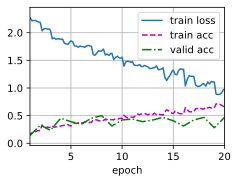

In [14]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()  # 每隔4个epoch，学习率降低为原来的90%
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 1.012, train acc 0.643
558.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


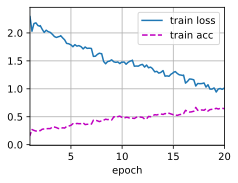

In [15]:
# 确定好超参数后，再在整个训练集上训练一遍
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)